# lets get some RF + PCAs going

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
CARIACO = pd.read_csv("../DATA/January/Combined_CARIACO_data_v5.csv")
CARIACO['date'] = pd.to_datetime(CARIACO['time_month'])
CARIACO = CARIACO.set_index('date')

In [4]:
CARIACO.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 1995-11-01 to 2021-11-01
Data columns (total 96 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    316 non-null    int64  
 1   cdww                          299 non-null    float64
 2   iews                          299 non-null    float64
 3   inss                          299 non-null    float64
 4   mcc                           299 non-null    float64
 5   mwp                           299 non-null    float64
 6   si10                          299 non-null    float64
 7   sp                            300 non-null    float64
 8   sst                           299 non-null    float64
 9   t2m                           299 non-null    float64
 10  tauoc                         299 non-null    float64
 11  u10                           299 non-null    float64
 12  ust                           300 non-null   

## Create Subframes without NAs

In [5]:
CSUB1 = CARIACO[['u10',
         'sst',
         'mtpr',
         'cdir',
         'e',
         'Satellite_chla',
        ]].dropna()

CSUB1.columns

Index(['u10', 'sst', 'mtpr', 'cdir', 'e', 'Satellite_chla'], dtype='object')

# scatter plot function

In [48]:
def plot_scatter_matrix(data, colnamelist):
    """plot scatter matrix of data"""
    
    ax0 = pd.plotting.scatter_matrix(data, diagonal='kde', figsize=(10, 10))
        
    xlen = len(ax0[0,:])
    ylen = len(ax0[:,0])
    
    for ax, i in zip(ax0[:,0], range(ylen)):
        ax.set_ylabel(colnamelist[i], fontsize=14, weight='bold')
        
    for ax, i in zip(ax0[ylen-1,:], range(xlen)):
        ax.set_xlabel(colnamelist[i], fontsize=14, weight='bold')
        
    for ax in ax0.flatten():
        ax.xaxis.label.set_rotation(45)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.label.set_ha('right')

    plt.tight_layout()
    plt.show()

    # plt.savefig('Plots/PRESENTATION_ScatterMatrix.png')

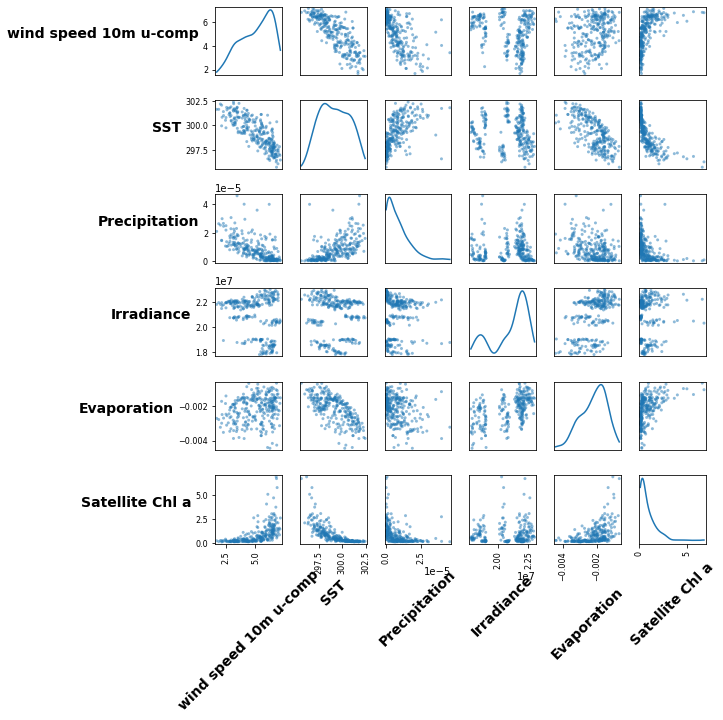

In [49]:
colnamelist = ['wind speed 10m u-comp', 'SST', 'Precipitation', 'Irradiance',
                   'Evaporation', 'Satellite Chl a']

plot_scatter_matrix(CSUB1, colnamelist)

# PCA

In [9]:


#pca_pytho.explained_variance_ratio_[0:2] * 100

In [50]:
# ------------------------------
# Principal Component Analysis 
# ------------------------------
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib.gridspec import GridSpec

def pca_analysis(dataP, colnamelist):
    """ PCA function """
    colnum = len(colnamelist)
    scaler = StandardScaler()
    scaler.fit(dataP)
    scaled_dataP = scaler.transform(dataP)

    pca_pytho = PCA(n_components=colnum, whiten=True)
    pcaresult = pca_pytho.fit_transform(scaled_dataP)
    expl_var = pca_pytho.explained_variance_ratio_[0:2] * 100
    print(expl_var)
    pcacoef = pd.DataFrame(columns=['PC1', 'PC2', 'VarName', 'VarColor'])
    pcacoef.PC1 = np.transpose(pca_pytho.components_)[:, 0]
    pcacoef.PC2 = np.transpose(pca_pytho.components_)[:, 1]
    pcacoef.VarName = colnamelist
    pcacoef.VarColor = ['grey', 'grey', 'grey', 'grey', 'grey', 'black']
    scalex = 1. / (pcaresult[:, 0].max() - pcaresult[:, 0].min())
    scaley = 1. / (pcaresult[:, 1].max() - pcaresult[:, 1].min())

    # need more values here
    offsetx = [1.15, 1.15, 1.25, 1.25, 1.25, 1.25]
    offsety = [1.15, 1.15, 1.25, 1.20, 1.15, 1.10]

    fig1 = plt.figure()
    gs = GridSpec(4, 4)
    ax1 = plt.subplot(gs[:, 1:3])
    ax2 = plt.subplot(gs[0:2, 3:4])
    ax3 = plt.subplot(gs[2:4, 3:4])

    ax1.scatter(pcaresult[:, 0], pcaresult[:, 1])
    for i in range(pcacoef.shape[0]):
        ax1.arrow(0, 0, pcacoef.PC1[i] / scalex, pcacoef.PC2[i] / scaley, color=pcacoef.VarColor[i], linewidth=2, alpha=0.6,
                  head_width=0.15, head_length=0.15)
        ax1.text(pcacoef.PC1[i] * offsetx[i] / scalex, pcacoef.PC2[i] * offsety[i] / scaley, pcacoef.VarName[i],
                 color=pcacoef.VarColor[i], ha='center', va='center')
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-5, 4)
    ax1.set_xlabel(r'PC1 ({expl:.2f} $\%$ variance explained)'.format(expl=expl_var[0]), fontsize=14, weight='bold')
    ax1.set_ylabel(r'PC2 ({expl:.2f} $\%$ variance explained)'.format(expl=expl_var[1]), fontsize=14, weight='bold')

    ax2.barh(range(colnum), pcacoef.sort_values(by=['PC1']).PC1 * 1.15 / scalex, color=pcacoef.sort_values(by=['PC1']).VarColor)
    ax2.set_xlim(-4, 4)
    ax2.set_xticklabels([])
    ax2.yaxis.tick_right()
    ax2.set_yticks(np.arange(colnum))
    ax2.set_yticklabels(pcacoef.sort_values(by=['PC1']).VarName)
    ax2.text(-3.5, 6, 'PC1', fontsize=12, weight='bold')

    ax3.barh(range(colnum), pcacoef.sort_values(by=['PC2']).PC2 * 1.15 / scaley, color=pcacoef.sort_values(by=['PC2']).VarColor)
    ax3.set_xlim(-4, 4)
    ax3.yaxis.tick_right()
    ax3.set_yticks(np.arange(colnum))
    ax3.set_yticklabels(pcacoef.sort_values(by=['PC2']).VarName)
    ax3.set_xlabel('Loadings', fontsize=14, weight='bold')
    ax3.text(-3.5, 6, 'PC2', fontsize=12, weight='bold')

    fig1.set_figheight(6)
    fig1.set_figwidth(12)
    plt.tight_layout()
    #plt.show()
    #fig1.savefig('Plots/PRESENTATION_PCA_tests.png')

[53.8064182  25.05364389]


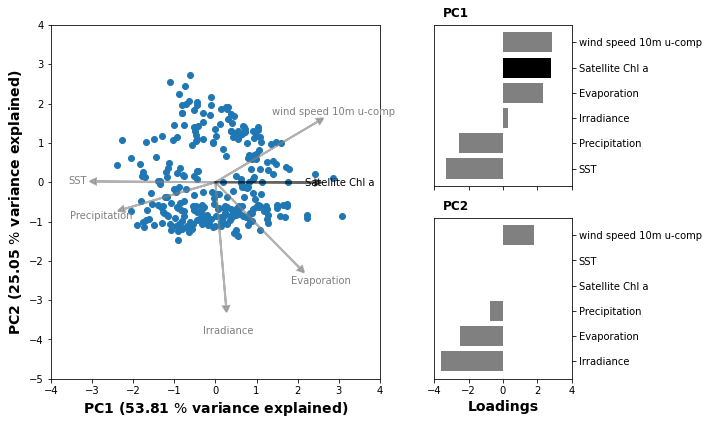

In [51]:
pca_analysis(CSUB1, colnamelist)

# RANDOM FOREST

In [53]:
dataP = CSUB1

/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF Chlorophyll: oob-error=0.42, r^2=0.65, % variance explained=65.92
                 VarName  Satellite_chla
0  wind speed 10m u-comp        7.969738
1                    SST       72.437449
2          Precipitation        2.669950
3             Irradiance        5.037676
4            Evaporation       11.885187
2     2.669950
3     5.037676
0     7.969738
4    11.885187
1    72.437449
Name: Satellite_chla, dtype: float64
RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)


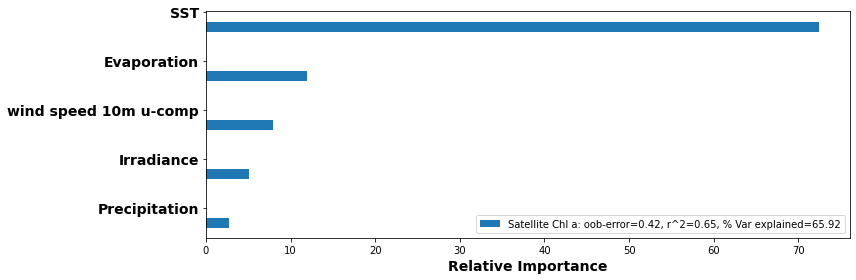

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score


testsize = 0.25
vars2take = [0, 1, 2, 3, 4]
#Chlorophyll

X_trainBiom, X_testBiom, y_trainBiom, y_testBiom = train_test_split(dataP.take(vars2take, axis=1), 
                                                                    dataP.Satellite_chla,
                                                                    test_size=testsize)
RFregBiomass = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
RFregBiomass.fit(X_trainBiom, y_trainBiom)
predicted_testBiom = RFregBiomass.predict(X_testBiom)




print('RF Chlorophyll: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass.oob_score_, RFregBiomass.score(X_testBiom, y_testBiom),
    explained_variance_score(y_testBiom, predicted_testBiom) * 100))



# change attributes below!
RFVarImp = pd.DataFrame(columns=['VarName', 'Satellite_chla'])
RFVarImp.VarName = colnamelist[:5]
RFVarImp.Satellite_chla = RFregBiomass.feature_importances_ * 100

print(RFVarImp)
print(RFVarImp.sort_values(by=['Satellite_chla']).Satellite_chla)
print(RFregBiomass)


fig2 = plt.figure()
varRFnum = 5
plt.barh(np.arange(varRFnum) - 0.3, RFVarImp.sort_values(by=['Satellite_chla']).Satellite_chla, height=.2,
         label='Satellite Chl a: oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - RFregBiomass.oob_score_, RFregBiomass.score(X_testBiom, y_testBiom),
             explained_variance_score(y_testBiom, predicted_testBiom) * 100))



plt.yticks(np.arange(varRFnum), RFVarImp.sort_values(by=['Satellite_chla']).VarName, fontsize=14, weight='bold')
plt.xlabel('Relative Importance', fontsize=14, weight='bold')
plt.legend()#fontsize='x-small')
fig2.set_figheight(4)
fig2.set_figwidth(12)
plt.tight_layout()
plt.show()
#fig2.savefig('PRESENTATION_TEST_RandomFOrest.png')